In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Loading in data

In [2]:
input_data = []
output_data = []

for i in range(10000):
    try:
        data = np.loadtxt(f'../sequences/testimg-{i}-targetdata.txt', delimiter=' ')
    except FileNotFoundError:
        print(f"❌ File not found at path: {i}")
        continue
    
    inputOneshot = data[0, 0:10]
    outputStrokes = data[:, 10:]
    outputStrokes[:, 0] = outputStrokes[:, 0]/28
    outputStrokes[:, 1] = outputStrokes[:, 1]/28
    
    
    input_data.append(inputOneshot)
    output_data.append(outputStrokes)

In [3]:
def draw_stroke_sequence(sequence, save_path=None, show=True):
    """
    sequence: numpy array or list of shape (T, 4) where each row is [dx, dy, eos, eod]
    save_path: optional path to save the plot as an image
    show: whether to display the plot
    """
    x, y = 0, 0
    xs, ys = [], []

    for dx, dy, eos, eod in sequence:
        x += dx*28
        y += dy*28
        xs.append(x)
        ys.append(y)

        if eos > 0.5:  # end of stroke
            xs.append(None)
            ys.append(None)

        if eod > 0.5:
            break

    plt.figure(figsize=(2, 2))
    plt.plot(xs, ys, linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.axis('equal')
    
    plt.show()

In [4]:
def getNumFromOneHot(inp):
    for i in range(10):
        if inp[i] == 1:
            return i

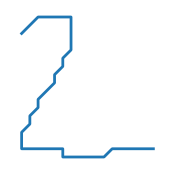

In [5]:
draw_stroke_sequence(output_data[1])

Data Processing

In [6]:
# Finding the max length of a sequence
max_length = 0
j = 0
for i in range(len(output_data)):
    if len(output_data[i]) > max_length:
        max_length = len(output_data[i])
    j += 1

print(max_length)
print(j)

108
10000


In [7]:
print(len(output_data))

10000


In [27]:
# Padding the sequences so that they are all the same size (good for batching)
padded_output_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_output_data[i, :len(output_data[i]), :] = output_data[i]
    padded_output_data[i, len(output_data[i]):, :] = [0, 0, 0, 1]

In [28]:
padded_input_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_input_data[i, 0, :] = [0, 0, 0, 0]
    padded_input_data[i, 1:, :] = padded_output_data[i, :max_length-1, :]

In [29]:
class StrokeDataset(Dataset):
    def __init__(self, onehot, inputs, outputstroke):
        self.digit = onehot                     # shape: [N]
        self.inputstroke = inputs               # list of [seq_len, 4] arrays
        self.outputstroke = outputstroke        # list of [seq_len, 4] arrays

    def __len__(self):
        return len(self.digit)

    def __getitem__(self, idx):
        digit = self.digit[idx]
        inputs = self.inputstroke[idx]
        outputs = self.outputstroke[idx]
        return torch.tensor(digit, dtype=torch.float32), torch.tensor(inputs, dtype=torch.float32), torch.tensor(outputs, dtype=torch.float32)

In [30]:
strokeDataset = StrokeDataset(input_data, padded_input_data, padded_output_data)

In [31]:
loader = DataLoader(strokeDataset, batch_size=32, shuffle=True)

Creating Model

Notes


RNN:
input_size = output_size 


In [32]:
class DigitToStrokeLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, batch_size=32):
        super(DigitToStrokeLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.embedding = nn.Linear(10, hidden_size)  # From one-hot to hidden dim
        
        # LSTM
        # Output layer: predicts [dx, dy, eos, eod]
        # Inital hidden state is the one-hot of number
        # Initial input is [0, 0, 0, 0, 0]
        # Input at t > 0 is output from t-1
        
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Output layer: predicts [dx, dy, eos, eod]
        self.output_head = nn.Linear(hidden_size, 4)
        self.sigmoid = nn.Sigmoid()  # For eos/eod
        self.tanh = nn.Tanh()


    def forward(self, x, hidden=None, onehot_digit=None):
        
        if onehot_digit != None and hidden == None:
            # Embed the digit
            h0 = self.embedding(onehot_digit)
            h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = torch.zeros_like(h0)
            hidden = (h0, c0)

        elif hidden == None and onehot_digit == None:
            hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                      torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
            
        out, hidden = self.lstm(x, hidden)
        
        out = self.output_head(out)
        
        out[:, :, 0:2] = self.tanh(out[:, :, 0:2])
        # out[:, :, 2:] = self.sigmoid(out[:, :, 2:])
        
        return out, hidden

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DigitToStrokeLSTM().to(device)
dx_dy_loss_fn = nn.MSELoss()
eos_eod_loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for (dig, input_seq, output_seq) in loader:
        # stroke_seq: [batch, seq_len, 4]
        input_seq = input_seq.to(device)
        target_seq = output_seq.to(device)
        dig = dig.to(device)

        pred_seq, hidden = model(input_seq, onehot_digit = dig)  # [batch, seq_len-1, 4]

        # Separate predictions
        pred_dxdy = pred_seq[..., :2]         # [batch, seq_len-1, 2]
        pred_eos_eod = pred_seq[..., 2:]      # [batch, seq_len-1, 2]

        # Separate targets
        target_dxdy = target_seq[..., :2]
        target_eos_eod = target_seq[..., 2:]

        # Compute losses
        loss_dxdy = dx_dy_loss_fn(pred_dxdy, target_dxdy)
        loss_eos_eod = eos_eod_loss_fn(pred_eos_eod, target_eos_eod)

        loss = loss_dxdy + loss_eos_eod

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

Epoch 1 | Loss: 25.1365
Epoch 2 | Loss: 12.5855
Epoch 3 | Loss: 12.2693
Epoch 4 | Loss: 12.1136
Epoch 5 | Loss: 12.0077


[ 0.03272252 -0.01660399  0.          0.        ]
[ 0.03402515 -0.01014511  0.          0.        ]
[ 0.03120978 -0.00942927  0.          0.        ]
[0.02544003 0.00680723 0.         0.        ]
[0.0161071  0.01459462 0.         0.        ]
[0.00798515 0.02365777 0.         0.        ]
[-0.00293649  0.03274217  0.          0.        ]
[-0.00637524  0.03226366  0.          0.        ]
[-0.00760479  0.03066226  0.          0.        ]
[-0.00745069  0.03314088  0.          0.        ]
[-0.00602899  0.03488431  0.          0.        ]
[-0.00294009  0.03336725  0.          0.        ]
[0.00069171 0.0294662  0.         0.        ]
[0.00214714 0.02449873 0.         0.        ]
[0.0023198  0.02244289 0.         0.        ]
[0.00120652 0.0222239  0.         0.        ]
[0.00158428 0.0233448  0.         0.        ]
[0.00395407 0.02508419 0.         0.        ]
[0.00485264 0.0274777  0.         0.        ]
[0.0043787  0.03011967 0.         0.        ]
[0.00340309 0.02794293 0.         0.        

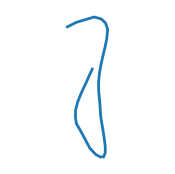

In [ ]:
def generate_text(number):
    model.eval()
    
    temp_onehot = np.zeros(10)
    temp_onehot[number] = 1
    temp_onehot = torch.tensor(temp_onehot, dtype=torch.float32).to(device)
    
    initial_input = torch.tensor([0, 0, 0, 0], dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(1)
    
    outputs = []
    
    output, hidden = model(initial_input, onehot_digit=temp_onehot)
    output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()

    outputs.append(output[:, -1, :].detach().cpu().numpy()[0])

    for i in range(max_length-1):
        output, hidden = model(output, hidden=hidden)
        output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()
        outputs.append(output[:, -1, :].detach().cpu().numpy()[0])
        
        print(outputs[-1])
        if output[:, -1, 3] == 1:
            print("HI")
            break
    
    draw_stroke_sequence(outputs)


[ 0.03088494 -0.00844406  0.          0.        ]
[ 0.02031474 -0.0081905   0.          0.        ]
[0.01339131 0.00354827 0.         0.        ]
[0.01300013 0.0076798  0.         0.        ]
[0.00914745 0.01133614 0.         0.        ]
[0.00614181 0.01786359 0.         0.        ]
[0.00178194 0.02448051 0.         0.        ]
[0.00063624 0.0255925  0.         0.        ]
[-5.4896343e-05  2.6210783e-02  0.0000000e+00  0.0000000e+00]
[-0.00037342  0.03015714  0.          0.        ]
[0.00059756 0.03321504 0.         0.        ]
[0.00194142 0.03498397 0.         0.        ]
[0.00444413 0.03513817 0.         0.        ]
[0.00825907 0.03328623 0.         0.        ]
[0.01129275 0.03229221 0.         0.        ]
[0.01301605 0.03342851 0.         0.        ]
[0.01458209 0.03404956 0.         0.        ]
[0.01499414 0.03485171 0.         0.        ]
[0.014991   0.03491335 0.         0.        ]
[0.01740294 0.03258666 0.         0.        ]
[0.01823854 0.02604053 0.         0.        ]
[0.016

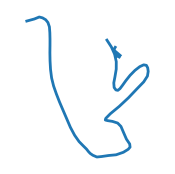

In [50]:
generate_text(2)